## Week 4 assignment: Defining problems and relevant data

### Question 1

**Instruction**: Clearly define a problem or an idea of your choice, where you would need to leverage the Foursquare location data to solve or execute. Remember that data science problems always target an audience and are meant to help a group of stakeholders solve a problem, so make sure that you explicitly describe your audience and why they would care about your problem.

In this project, I will implement a system that recommends neighborhoods to move in based on the preferences of a person looking for an apartment. People pick a neighborhood to live in for different reasons (affordability, distance to their work or school, etc.), but one factor that a lot of them consider is whether the neighborhood has certain types of stores or places nearby that they like. For instance, a person might want to live in a neighborhood with lots of good restaurants, or another person might want a park close to their place. I am thus planning to create a system that could be used on an online apartment marketplace (like [Zillow](https://www.zillow.com/)) that gathers information about different neighborhoods in a city via Foursquare location data, asks the customer what kind of stores or places they want their place to be close to, and pushes neighborhood recommendations based on the preferences. Although realistically customers should be able to choose which city they live in, I will focus on the city of Seattle, where I spent a year and I would LOVE to go back there one day! 

### Question 2

**Instruction**: Describe the data that you will be using to solve the problem or execute your idea. Remember that you will need to use the Foursquare location data to solve the problem or execute your idea. You can absolutely use other datasets in combination with the Foursquare location data. So make sure that you provide adequate explanation and discussion, with examples, of the data that you will be using, even if it is only Foursquare location data.

For retrieving information about neighborhoods in Seattle, I will use [Apartment List](https://www.apartmentlist.com/renter-life/average-rent-in-seattle), a website that lists neighborhoods in a city as well as the average rent (and average rent per 750 sqft) for each neighborhood. In order to tie each neighborhood with a specific longitude and latitude, I will use google map to look up each neighborhood and write down their longitude and latitude. Although this is a tedious step, I believe this will not be too time-consuming for one city. Besides, I could not find any datasets that display both geographical information such as zip codes and neighborhood names in Seattle, along with their average rent.

For collecting information about businesses and amenities in different neighborhoods, I will use the Foursquare location data. The data enables us to search for a specific type of venues around a given location, learn more about the specific venues such as the tips provided by Foursquare users, and explore trending venues around a given location. I will mostly use the last feature in order to figure out what type of venues one can expect the most from each neighborhood, and make recommendations accordingly.

### Example of datasets

Below is the first 3 rows of what my Seattle neighborhood + rent + longitude&latitude dataset should look like.

Neighborhood  | Average_Rent  | Average_Rent_750     | Longitude          | Latitude
------------- | ------------- | -------------------  | ------------------ | -------------
Belltown      | 2,245         | 2,359                | 47.614709015632435 | -122.34526800898152
Lake Union    | 2,146         | 2,275                | 47.64139838880749  | -122.3329762894856
Downtown      | 2,119         | 2,301                | 47.60619289008479  | -122.33253325887549

## Week 5: Implementation, analysis and write-up

### Step 1: Preparing a Seattle neighborhood dataset with longitudes and latitudes

First of all, I will generate a dataset with different neighborhoods in Seattle and their average rent by scraping from [this website](https://www.zumper.com/rent-research/seattle-wa). It is different from the website that I said I would refer to in the last week's assignment - this one has more information from a lot more neighborhoods.

Let's start with a cell importing the libraries we will need.

In [5]:
import pandas as pd
import numpy as np
import requests
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium

Solving environment: done

# All requested packages already installed.



In [6]:
source = requests.get('https://www.zumper.com/rent-research/seattle-wa').text
soup = BeautifulSoup(source, 'html5lib')

In [7]:
My_table = soup.find('table', {'class': 'NeighborhoodRent_table__2AiTW'})

In [8]:
tds = My_table.findAll('td')

Neighborhoods = []
Average_Rent = []
for i in range(len(tds)):
    if i in list(range(0,len(tds),2)):
        Neighborhoods.append(tds[i].text.strip())
    elif i in list(range(1,len(tds),2)):
        Average_Rent.append(tds[i].text.strip())

In [9]:
dat = {'Neighborhood':Neighborhoods, 'Average_Rent':Average_Rent}
df_Seattle = pd.DataFrame(dat)
df_Seattle.head()

,Neighborhood,Average_Rent
0,Broadway,"$1,495"
1,Belltown,"$1,935"
2,University District,"$1,253"
3,Lower Queen Anne,"$1,669"
4,First Hill,"$1,581"


Now I have to add information about the longitude and latitude of each neighborhood. Though this is not ideal, I will do so by copying and pasting the lon&lat information from google map and adding the results on the `df_Seattle` dataset. 
After that, let's import the updated dataset and make sure everything looks good.

In [10]:
df_Seattle_lonlat = pd.read_csv('df_Seattle_lonlat.csv')

#Pre-process the rent variable
df_Seattle_lonlat['Average_Rent'] = df_Seattle_lonlat['Average_Rent'].str.replace(',', '').str.replace('$', '').astype(int)
df_Seattle_lonlat.tail()

,Unnamed: 0,Neighborhood,Average_Rent,Latitude,Longitude
70,70,Sunset Hill,1780,47.681495,-122.398730
71,71,Laurelhurst,1423,47.660952,-122.285231
72,72,Madison Park,1475,47.635053,-122.282052
73,73,Portage Bay,1575,47.646929,-122.320004
74,74,View Ridge,1595,47.684752,-122.274773


Let's visualize the table above to where different neighborhoods are in Seattle.

In [11]:
address = 'Seattle, WA'

geolocator = Nominatim(user_agent="wa_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [12]:
map_Seattle = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, neighborhood in zip(df_Seattle_lonlat['Latitude'], df_Seattle_lonlat['Longitude'], df_Seattle_lonlat['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Seattle)

map_Seattle

### Step 2: Combining the dataset with Foursquare venue info

I'll first define Foursquare credentials and version.

In [13]:
CLIENT_ID = 'JQTSUMMAW4B4PCAVBUSJCXJBCX4ICX353MVBHQANDEKSYYKU'
CLIENT_SECRET = 'VWYLGGF3HHKBC1ZAPMAUF5DYWBN4ZWQTDCWOB4FOIO11U0LL'
VERSION = '20201212'
LIMIT = 100

Let's create a function to get 100 venues in all the neighborhoods in Seattle within a radius of 500 meters.

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Run the above function on each neighborhood of Seattle, and create a new dataframe.

In [15]:
Seattle_venues = getNearbyVenues(df_Seattle_lonlat['Neighborhood'], df_Seattle_lonlat['Latitude'], df_Seattle_lonlat['Longitude'])
Seattle_venues.head()

Broadway
Belltown
University District
Lower Queen Anne
First Hill
South-Lake Union
Fremont
Lake City
Minor
Wallingford
Stevens
Adams
Junction
Central Business District
Roosevelt
North Queen Anne
Greenwood
Green Lake
Eastlake
Atlantic
Pike Place Market
Columbia City
Westlake
North Admiral
Maple Leaf
West Woodland
East Queen Anne
Alki
North College Park
North Beacon Hill
Fairmount Park
Mann
Lawton Park
Mt. Baker
Ravenna
International District
Mid-Beacon Hill
West Queen Anne
Phinney Ridge
North Delridge
Loyal Heights
Genesee
Bitter Lake
Brighton
Crown Hill
Haller Lake
Pinehurst
Pioneer Square
Madrona
Riverview
Wedgwood
Montlake
Leschi
Bryant
High Point
South Delridge
Seward Park
Georgetown
SoDo
Southeast Magnolia
Gatewood
North Beach - Blue Ridge
Interbay
Highland Park
Seaview
Dunlap
Broadview
Roxhill
Fauntleroy
Whittier Heights
Sunset Hill
Laurelhurst
Madison Park
Portage Bay
View Ridge


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Broadway,47.625314,-122.324739,Top Pot Doughnuts,47.624630,-122.325470,Donut Shop
1,Broadway,47.625314,-122.324739,Harry's Fine Foods,47.624402,-122.326771,Restaurant
2,Broadway,47.625314,-122.324739,Sol Liquor Lounge,47.624605,-122.325434,Cocktail Bar
3,Broadway,47.625314,-122.324739,Barjot,47.625701,-122.326748,Café
4,Broadway,47.625314,-122.324739,Single Shot,47.624688,-122.325431,American Restaurant


From the test below, it seems like there are no venues around one neighborhood (View Ridge), so I will delete the row with this neighborhood from `df_Seattle_lonlat`.

In [16]:
len(Seattle_venues['Neighborhood'].unique()) == len(df_Seattle_lonlat) #returns false

df_Seattle_lonlat = df_Seattle_lonlat[df_Seattle_lonlat.Neighborhood != 'View Ridge']

Let's analyze each neighborhood to see what types of venues are popular. First, the code below conducts a one-hot encoding for all the venue categories.

In [17]:
Seattle_onehot = pd.get_dummies(Seattle_venues[['Venue Category']], prefix="", prefix_sep="")
Seattle_onehot['Neighborhood'] = Seattle_venues['Neighborhood'] 
first_col = Seattle_onehot.pop('Neighborhood')
Seattle_onehot.insert(0, 'Neighborhood', first_col)
Seattle_venues['Neighborhood'].unique()

array(['Broadway', 'Belltown', 'University District', 'Lower Queen Anne',
       'First Hill', 'South-Lake Union', 'Fremont', 'Lake City', 'Minor',
       'Wallingford', 'Stevens', 'Adams', 'Junction',
       'Central Business District', 'Roosevelt', 'North Queen Anne',
       'Greenwood', 'Green Lake', 'Eastlake', 'Atlantic',
       'Pike Place Market', 'Columbia City', 'Westlake', 'North Admiral',
       'Maple Leaf', 'West Woodland', 'East Queen Anne', 'Alki',
       'North College Park', 'North Beacon Hill', 'Fairmount Park',
       'Mann', 'Lawton Park', 'Mt. Baker', 'Ravenna',
       'International District', 'Mid-Beacon Hill', 'West Queen Anne',
       'Phinney Ridge', 'North Delridge', 'Loyal Heights', 'Genesee',
       'Bitter Lake', 'Brighton', 'Crown Hill', 'Haller Lake',
       'Pinehurst', 'Pioneer Square', 'Madrona', 'Riverview', 'Wedgwood',
       'Montlake', 'Leschi', 'Bryant', 'High Point', 'South Delridge',
       'Seward Park', 'Georgetown', 'SoDo', 'Southeast Magnol

Group rows by neighborhood and by take the mean of the frequency of occurrence of each category.

In [60]:
Seattle_grouped = Seattle_onehot.groupby('Neighborhood').mean().reset_index()

,Neighborhood,ATM,Accessories Store,African Restaurant,Airport,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Adams,0.000000,0.0,0.0,0.000000,0.00,0.000000,0.0,0.0,0.00,...,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0,0.000000
1,Alki,0.000000,0.0,0.0,0.000000,0.00,0.000000,0.0,0.0,0.00,...,0.00,0.0,0.000000,0.028571,0.0,0.0,0.0,0.00,0.0,0.000000
2,Atlantic,0.000000,0.0,0.0,0.000000,0.00,0.000000,0.0,0.0,0.00,...,0.00,0.0,0.000000,0.184211,0.0,0.0,0.0,0.00,0.0,0.026316
3,Belltown,0.000000,0.0,0.0,0.000000,0.03,0.000000,0.0,0.0,0.01,...,0.01,0.0,0.000000,0.020000,0.0,0.0,0.0,0.01,0.0,0.000000
4,Bitter Lake,0.034483,0.0,0.0,0.000000,0.00,0.034483,0.0,0.0,0.00,...,0.00,0.0,0.034483,0.103448,0.0,0.0,0.0,0.00,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,Wedgwood,0.083333,0.0,0.0,0.000000,0.00,0.000000,0.0,0.0,0.00,...,0.00,0.0,0.083333,0.000000,0.0,0.0,0.0,0.00,0.0,0.000000
70,West Queen Anne,0.000000,0.0,0.0,0.000000,0.00,0.000000,0.0,0.0,0.00,...,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0,0.000000
71,West Woodland,0.000000,0.0,0.0,0.000000,0.00,0.000000,0.0,0.0,0.00,...,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0,0.000000
72,Westlake,0.058824,0.0,0.0,0.058824,0.00,0.000000,0.0,0.0,0.00,...,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0,0.000000


Create the new df and display the top 10 venues for each neighborhood. First, let's make a function to sort the venues in descending order.

In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [127]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Seattle_grouped['Neighborhood']

for ind in np.arange(Seattle_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Seattle_grouped.iloc[ind, :], num_top_venues)



In [67]:
neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adams,Burger Joint,Ice Cream Shop,Cocktail Bar,Coffee Shop,Mexican Restaurant,Sushi Restaurant,Bakery,Thai Restaurant,New American Restaurant,Bar
1,Alki,Park,Italian Restaurant,Coffee Shop,Mexican Restaurant,Art Gallery,Fish & Chips Shop,Restaurant,Tennis Court,Ice Cream Shop,Café
2,Atlantic,Vietnamese Restaurant,Pizza Place,Martial Arts School,Plaza,Thrift / Vintage Store,Coffee Shop,Yoga Studio,Café,Beer Bar,Breakfast Spot
3,Belltown,Bar,Seafood Restaurant,Pizza Place,Sushi Restaurant,Coffee Shop,Gym,American Restaurant,Italian Restaurant,Breakfast Spot,Hotel
4,Bitter Lake,Vietnamese Restaurant,Fast Food Restaurant,Marijuana Dispensary,Automotive Shop,Dive Bar,Steakhouse,Sports Bar,Sandwich Place,Restaurant,Pizza Place
...,...,...,...,...,...,...,...,...,...,...,...
69,Wedgwood,Park,Coffee Shop,ATM,Gym,Supermarket,Steakhouse,Pharmacy,Bank,Video Store,Pub
70,West Queen Anne,Bus Stop,Furniture / Home Store,Coffee Shop,Pilates Studio,Café,Taco Place,Bakery,Garden,Supplement Shop,Food
71,West Woodland,Brewery,Pizza Place,Food Truck,Gastropub,Bus Station,Gas Station,Chinese Restaurant,Automotive Shop,Park,Intersection
72,Westlake,Coffee Shop,Sandwich Place,ATM,Track,Harbor / Marina,Hotel,Gym,Italian Restaurant,Deli / Bodega,Pier


### Step 3: Cluster neighborhoods

In my recommendation system, customers should be able to see more than one neighborhood options based on their preferences.
In order to recommend multiple neighborhoods that are similar, I will conduct a k-means clustering to group neighborhoods together based on their similarities.

Let's use the elbow method to determine the optimal k.

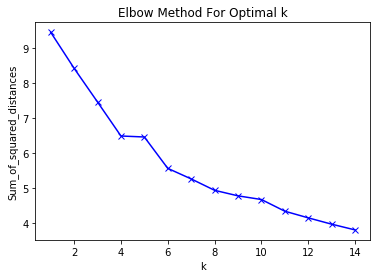

In [22]:
Seattle_grouped_clustering = Seattle_grouped.drop('Neighborhood', 1)

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Seattle_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

It looks like the elbow is around 7. Let us try grouping neighborhoods into 7 clusters.

In [23]:
kclusters = 7
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Seattle_grouped_clustering)
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1], dtype=int32)

Now, let's create a new df that includes the cluster as well as the top 10 venues for each neighborhood.

In [24]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
Seattle_merged = df_Seattle_lonlat
Seattle_merged = Seattle_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [25]:
Seattle_merged.groupby('Cluster Labels')['Neighborhood'].count()

Cluster Labels
0     3
1    61
2     1
3     3
4     3
5     1
6     2
Name: Neighborhood, dtype: int64

In [26]:
Seattle_merged

,Unnamed: 0,Neighborhood,Average_Rent,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Broadway,1495,47.625314,-122.324739,1,Bar,Park,Cocktail Bar,Coffee Shop,Italian Restaurant,Shipping Store,Thai Restaurant,Restaurant,Spa,Yoga Studio
1,1,Belltown,1935,47.614646,-122.344796,1,Bar,Seafood Restaurant,Pizza Place,Sushi Restaurant,Coffee Shop,Gym,American Restaurant,Italian Restaurant,Breakfast Spot,Hotel
2,2,University District,1253,47.663065,-122.314097,1,Thai Restaurant,Bubble Tea Shop,Chinese Restaurant,Indian Restaurant,Mexican Restaurant,Korean Restaurant,Café,Movie Theater,Deli / Bodega,Tea Room
3,3,Lower Queen Anne,1669,47.624803,-122.356765,1,Coffee Shop,Performing Arts Venue,Indie Movie Theater,Opera House,Yoga Studio,Café,Japanese Restaurant,Lounge,Bookstore,Mediterranean Restaurant
4,4,First Hill,1581,47.609792,-122.323554,1,Sandwich Place,Coffee Shop,Italian Restaurant,Ramen Restaurant,Bar,Hotel,Asian Restaurant,Ice Cream Shop,Brewery,Food & Drink Shop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,69,Whittier Heights,1495,47.683087,-122.369702,4,Deli / Bodega,Bed & Breakfast,Park,Playground,Dumpling Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant,Event Space,Eye Doctor
70,70,Sunset Hill,1780,47.681495,-122.398730,1,Harbor / Marina,Post Office,Food,Playground,Coffee Shop,Park,Board Shop,Boat or Ferry,Gym / Fitness Center,Gym
71,71,Laurelhurst,1423,47.660952,-122.285231,1,Yoga Studio,Chinese Restaurant,Brewery,Pizza Place,Burger Joint,Bistro,Bus Stop,Steakhouse,Café,Food Truck
72,72,Madison Park,1475,47.635053,-122.282052,1,Bar,Bank,Park,Bakery,Track,New American Restaurant,Dry Cleaner,Mexican Restaurant,Korean Restaurant,Café


Let's visualize the clusters.

In [27]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(Seattle_merged['Latitude'], Seattle_merged['Longitude'], Seattle_merged['Neighborhood'], Seattle_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [28]:
cluster_1 = Seattle_merged.loc[Seattle_merged['Cluster Labels'] == 1, Seattle_merged.columns[[1] + list(range(5, Seattle_merged.shape[1]))]]
cluster_1.head()

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Broadway,1,Bar,Park,Cocktail Bar,Coffee Shop,Italian Restaurant,Shipping Store,Thai Restaurant,Restaurant,Spa,Yoga Studio
1,Belltown,1,Bar,Seafood Restaurant,Pizza Place,Sushi Restaurant,Coffee Shop,Gym,American Restaurant,Italian Restaurant,Breakfast Spot,Hotel
2,University District,1,Thai Restaurant,Bubble Tea Shop,Chinese Restaurant,Indian Restaurant,Mexican Restaurant,Korean Restaurant,Café,Movie Theater,Deli / Bodega,Tea Room
3,Lower Queen Anne,1,Coffee Shop,Performing Arts Venue,Indie Movie Theater,Opera House,Yoga Studio,Café,Japanese Restaurant,Lounge,Bookstore,Mediterranean Restaurant
4,First Hill,1,Sandwich Place,Coffee Shop,Italian Restaurant,Ramen Restaurant,Bar,Hotel,Asian Restaurant,Ice Cream Shop,Brewery,Food & Drink Shop


### Step 4: Add another variable

So far, the clusters based primarily on venues are not well-balanced in that too many neighborhoods belong to the second cluster (1). I will experiment with another variable to see if I can balance my clusters.

#### Proximity to light rail stations

Seattle has a light rail system connecting the University of Washington and Sea-Tac International Airport (as of 2020). A lot of people use it for commute, and they might want to live in a neighborhood close to a light rail station.

In [318]:
#pip install mpu --user
import mpu

     |████████████████████████████████| 69 kB 1.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


I have collected geographical information of all the light rail stations, which I will load below.

In [45]:
LR_df = pd.read_csv('LR_df.csv')

As an instance, let's find out the closest light rail station from Broadway neighborhood.

In [53]:
BW_lat = Seattle_merged['Latitude'][0]
BW_lon = Seattle_merged['Longitude'][0]

distances = []
for lat, lon in zip(LR_df['Latitude'], LR_df['Longitude']):
    distances.append(mpu.haversine_distance((lat, lon), (BW_lat, BW_lon)))

LR_distances = pd.DataFrame({'Station':LR_df['Station'].values, 'Distance':distances})

LR_closest = LR_distances.loc[LR_distances['Distance'] == min(LR_distances['Distance']), 'Station'].item()

print('The closest station from {} is {}, and it is {} kms away.'.format(Seattle_merged['Neighborhood'][0], 
                                                               LR_closest, 
                                                               min(LR_distances['Distance'])))

LR_distances.shape

The closest station from Broadway is Capitol Hill, and it is 0.698681295845244 kms away.


(16, 2)

Now let's do the same for all the neighborhoods, and merge the results on the `Seattle_merged` dataframe.

In [57]:
dist_to_closest_station = []
for nhood, lat1, lon1 in zip(Seattle_merged['Neighborhood'], Seattle_merged['Latitude'], Seattle_merged['Longitude']):
    distances = []
    for lat2, lon2 in zip(LR_df['Latitude'], LR_df['Longitude']):
        distances.append(mpu.haversine_distance((lat1, lon1), (lat2, lon2)))
        closest = min(distances)
    dist_to_closest_station.append(closest)

In [59]:
Seattle_merged['Distance to closest LR station (in km)'] = dist_to_closest_station
Seattle_merged.head()

,Unnamed: 0,Neighborhood,Average_Rent,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Distance to closest LR station (in km)
0,0,Broadway,1495,47.625314,-122.324739,1,Bar,Park,Cocktail Bar,Coffee Shop,Italian Restaurant,Shipping Store,Thai Restaurant,Restaurant,Spa,Yoga Studio,0.698681
1,1,Belltown,1935,47.614646,-122.344796,1,Bar,Seafood Restaurant,Pizza Place,Sushi Restaurant,Coffee Shop,Gym,American Restaurant,Italian Restaurant,Breakfast Spot,Hotel,0.680763
2,2,University District,1253,47.663065,-122.314097,1,Thai Restaurant,Bubble Tea Shop,Chinese Restaurant,Indian Restaurant,Mexican Restaurant,Korean Restaurant,Café,Movie Theater,Deli / Bodega,Tea Room,1.660603
3,3,Lower Queen Anne,1669,47.624803,-122.356765,1,Coffee Shop,Performing Arts Venue,Indie Movie Theater,Opera House,Yoga Studio,Café,Japanese Restaurant,Lounge,Bookstore,Mediterranean Restaurant,2.074938
4,4,First Hill,1581,47.609792,-122.323554,1,Sandwich Place,Coffee Shop,Italian Restaurant,Ramen Restaurant,Bar,Hotel,Asian Restaurant,Ice Cream Shop,Brewery,Food & Drink Shop,0.920669


In [133]:
Seattle_test = Seattle_grouped_clustering 
Seattle_test['Distance to closest LR station (in km)'] = dist_to_closest_station
Seattle_test = Seattle_test.drop('Average_Rent',1)
Seattle_test['Distance to closest LR station (in km)'].describe()

count    74.000000
mean      3.738759
std       2.578111
min       0.073937
25%       1.410334
50%       3.445650
75%       5.929138
max       9.275280
Name: Distance to closest LR station (in km), dtype: float64

In [125]:
kclusters_1 = 4
kmeans_1 = KMeans(n_clusters=kclusters_1, random_state=0).fit(Seattle_test)
kmeans_1.labels_[0:10] 

array([2, 2, 2, 0, 2, 2, 0, 3, 2, 0], dtype=int32)

In [128]:
neighborhoods_venues_sorted_test = neighborhoods_venues_sorted
neighborhoods_venues_sorted_test.insert(0, 'Cluster Labels', kmeans_1.labels_)
Seattle_merged_test = df_Seattle_lonlat
Seattle_merged_test = Seattle_merged_test.join(neighborhoods_venues_sorted_test.set_index('Neighborhood'), on='Neighborhood')

In [129]:
Seattle_merged_test.groupby('Cluster Labels')['Neighborhood'].count()

Cluster Labels
0    19
1    22
2    21
3    12
Name: Neighborhood, dtype: int64

In [131]:
map_clusters_test = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters_1)
ys = [i + x + (i*x)**2 for i in range(kclusters_1)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(Seattle_merged['Latitude'], Seattle_merged_test['Longitude'], Seattle_merged_test['Neighborhood'], Seattle_merged_test['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_test)
    
for lat, lng, station in zip(LR_df['Latitude'], LR_df['Longitude'], LR_df['Station']):
    label_st = '{}'.format(station)
    label_st = folium.Popup(label_st, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label_st,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.9,
        parse_html=False).add_to(map_clusters_test)
       
map_clusters_test

Okay, now the clusters are much more balanced, though I'm not sure if I can observe clear a tendency that certain clusters are close to a light rail station (indicated with a smaller blue dot on the map).

### Step 5: Create a recommendation system interface

Now it's time to create a system that pushes neighborhood recommendations based on the customer's preferences.

Let's first create a list of all the unique venues in the `Seattle_merged_test` data frame.

In [252]:
def NhoodRecommendation():
    restaurant_q = input("Hi there! Let me see if there is a neighborhood in Seattle you might like. \nFirst of all, what kind of restaurants do you like? \nPlease type 'Chinese,' 'American,' etc.: " )
    other_q_1 = input("Great! Please tell me a place you want in your neighborhood.: ")
    other_q_2 = input("Please tell me another place you want in your neighborhood.: ")
    other_q_3 = input("Please tell me one more place you want in your neighborhood. \nYou can also say 'Nope' if you don't have preferences : ")
    preferred_venues = [restaurant_q, other_q_1, other_q_2, other_q_3]
    matches = []
    for i in range(len(Seattle_merged_test)):
        match = 0
        for venue in preferred_venues:
            if venue in str(Seattle_merged_test.iloc[i, 6:15].values):
                match += 1
        matches.append(match)
    if max(matches) == 0:
        print("Your keywords didn't match any of the neighborhoods. Try again!")
    else:
        Seattle_merged_test['Number of matches'] = matches
        found_matches = Seattle_merged_test.loc[Seattle_merged_test['Number of matches'] == max(Seattle_merged_test['Number of matches'])]
        if len(found_matches) == 1:
            nhood = found_matches['Neighborhood'].iloc[0]
            rent = found_matches['Average_Rent'].iloc[0]
            dist = found_matches['Distance to closest LR station (in km)'].iloc[0]
            print('''We found a match with your preferences!
            {} neighborhood has the average rent of ${} and 
            {} km away from a light rail station.'''.format(nhood,rent,round(dist, 2)))
            other_recs = input("Would you like to see other recommendations? Type Y or N: ")
            if other_recs == "N":
                print("Goodbye!")
            elif other_recs == "Y":
                other_matches = Seattle_merged_test.loc[Seattle_merged_test['Cluster Labels'] == found_matches['Cluster Labels'].iloc[0]]
                other_matches = other_matches[other_matches['Neighborhood'] != nhood]
                first = other_matches['Neighborhood'].iloc[0]
                second = other_matches['Neighborhood'].iloc[1]
                third = other_matches['Neighborhood'].iloc[2]
                print("You might also want to check out neighborhoods like {}, {}, and {}!".format(first,second,third))
        elif len(found_matches) > 1:
            lowest_rent = found_matches.loc[found_matches['Average_Rent'] == min(found_matches['Average_Rent']), 'Neighborhood'].item()
            closest_LR = found_matches.loc[found_matches['Distance to closest LR station (in km)'] == min(found_matches['Distance to closest LR station (in km)']), 'Neighborhood'].item()
            print('''We found {} match(es) with your preferences!
            Among them, {} neighborhood has the lowest average rent of ${} and 
            {} is only {} km away from a light rail station.'''.format(len(found_matches), lowest_rent, min(found_matches['Average_Rent']), closest_LR, round(min(found_matches['Distance to closest LR station (in km)']),2)))
        
        
    

In [253]:
NhoodRecommendation()

Hi there! Let me see if there is a neighborhood in Seattle you might like. 
First of all, what kind of restaurants do you like? 
Please type 'Chinese,' 'American,' etc.: Japanese
Great! Please tell me a place you want in your neighborhood.: Theater
Please tell me another place you want in your neighborhood.: Park
Please tell me one more place you want in your neighborhood. 
You can also say 'Nope' if you don't have preferences : Nope
We found a match with your preferences!
            Lower Queen Anne neighborhood has the average rent of $1669 and 
            2.07 km away from a light rail station.
Would you like to see other recommendations? Type Y or N: Y
You might also want to check out neighborhoods like Belltown, First Hill, and Fremont!


### Step 6: Evaluation, discussion, and conclusion